In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers

# Векторизируем сгенерированные изображения. Будем сжимать их до размера (200, 200) и чернобелого цвета:

In [2]:
os.chdir('dataset_false')
for i in os.listdir():
    img = Image.open(i)
    img = img.resize((200, 200))
    arr = np.asarray(img, dtype='uint8')
    k = np.array([[[0.2989, 0.587, 0.114]]])
    sums = np.round(np.sum(arr*k, axis=2)).astype(np.uint8)
    sums = sums.reshape((1, 200, 200))
    if i != 'im0.png':
        data_false = np.append(data_false, sums, axis=0)
    else:
        data_false = np.array(sums)
os.chdir('..')

In [3]:
data_false.shape

(4999, 200, 200)

In [4]:
os.chdir('dataset_true')
for i in os.listdir():
    img = Image.open(i)
    img = img.resize((200, 200))
    arr = np.asarray(img, dtype='uint8')
    k = np.array([[[0.2989, 0.587, 0.114]]])
    sums = np.round(np.sum(arr*k, axis=2)).astype(np.uint8)
    sums = sums.reshape((1, 200, 200))
    if i != '0.png':
        data_true = np.append(data_true, sums, axis=0)
    else:
        data_true = np.array(sums)
os.chdir('..')

In [5]:
data_true.shape

(5000, 200, 200)

# Смёрджим, разметим и перемешаем данные:

In [6]:
data_x_train = np.concatenate((data_false[:4000], data_true[:4000]))
data_x_test = np.concatenate((data_false[4000:], data_true[4000:]))
data_y_train = np.concatenate((np.zeros(4000), np.ones(4000))).astype('int32')
data_y_test = np.concatenate((np.zeros(999), np.ones(1000))).astype('int32')

In [7]:
all_data_train = np.concatenate((data_x_train.reshape(8000, 40000), data_y_train.reshape(8000, 1)), axis=1)
all_data_test = np.concatenate((data_x_test.reshape(1999, 40000), data_y_test.reshape(1999, 1)), axis=1)

In [8]:
np.random.shuffle(all_data_train)
np.random.shuffle(all_data_test)

In [9]:
data_x_train = all_data_train[:, :-1].reshape(8000, 200, 200)
data_y_train = all_data_train[:, -1]
data_x_test = all_data_test[:, :-1].reshape(1999, 200, 200)
data_y_test = all_data_test[:, -1]

In [10]:
data_x_train.shape

(8000, 200, 200)

# Модель:

In [11]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=0.0001), metrics=['acc'])

# Обучение:

In [12]:
history = model.fit(data_x_train, data_y_train, epochs=5, validation_data=(data_x_test, data_y_test), steps_per_epoch=50)

Epoch 1/5
50/50 [==============================] - 328s 6s/step - loss: 31.4190 - acc: 0.6367 - val_loss: 2.5206 - val_acc: 0.4997
Epoch 2/5
50/50 [==============================] - 332s 7s/step - loss: 0.7718 - acc: 0.7670 - val_loss: 0.3625 - val_acc: 0.9385
Epoch 3/5
50/50 [==============================] - 331s 7s/step - loss: 0.4900 - acc: 0.8519 - val_loss: 0.3698 - val_acc: 0.9950
Epoch 4/5
50/50 [==============================] - 334s 7s/step - loss: 0.5420 - acc: 0.7719 - val_loss: 0.3558 - val_acc: 0.6448
Epoch 5/5
50/50 [==============================] - 332s 7s/step - loss: 0.2085 - acc: 0.9009 - val_loss: 0.0035 - val_acc: 0.9990


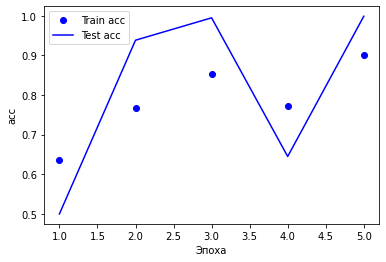

In [15]:
plt.plot(range(1, 6), history.history['acc'], 'bo', label='Train acc')
plt.plot(range(1, 6), history.history['val_acc'], 'b', label='Test acc')
plt.xlabel('Эпоха')
plt.ylabel('acc')
plt.legend()
plt.show()

# Так как модель не может достигнуть высокого результата на тренировочных данных, добавим еще один свёрточный слой. Пока что проигнорируем странное поведение результатов на тестовых данных.

In [16]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=0.0001), metrics=['acc'])

In [17]:
history = model.fit(data_x_train, data_y_train, epochs=10, validation_data=(data_x_test, data_y_test), steps_per_epoch=30)

Epoch 1/10
30/30 [==============================] - 351s 11s/step - loss: 6.3345 - acc: 0.8564 - val_loss: 0.0290 - val_acc: 0.9870
Epoch 2/10
30/30 [==============================] - 388s 13s/step - loss: 0.7465 - acc: 0.9131 - val_loss: 0.0939 - val_acc: 0.9640
Epoch 3/10
30/30 [==============================] - 378s 13s/step - loss: 0.3855 - acc: 0.9234 - val_loss: 0.0145 - val_acc: 0.9955
Epoch 4/10
30/30 [==============================] - 373s 12s/step - loss: 0.1620 - acc: 0.9699 - val_loss: 0.0132 - val_acc: 0.9945
Epoch 5/10
30/30 [==============================] - 373s 12s/step - loss: 0.0129 - acc: 0.9962 - val_loss: 0.0051 - val_acc: 0.9980
Epoch 6/10
30/30 [==============================] - 365s 12s/step - loss: 0.2857 - acc: 0.9601 - val_loss: 0.0080 - val_acc: 0.9965
Epoch 7/10
30/30 [==============================] - 421s 14s/step - loss: 0.0442 - acc: 0.9915 - val_loss: 0.0067 - val_acc: 0.9995
Epoch 8/10
30/30 [==============================] - 438s 15s/step - loss: 0.

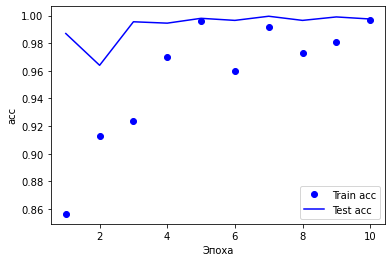

In [19]:
plt.plot(range(1, 11), history.history['acc'], 'bo', label='Train acc')
plt.plot(range(1, 11), history.history['val_acc'], 'b', label='Test acc')
plt.xlabel('Эпоха')
plt.ylabel('acc')
plt.legend()
plt.show()

In [20]:
model.save('model_1.0.h5')